In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

import locale
locale.setlocale(locale.LC_ALL, '')
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from dataloader import XRaySet, transform, collect_paths
from utils import Flatten, UnFlatten, for_plotting, to_uint8_array, plot_grid
from MS_SSIM import MS_SSIM

### Preprocessing & Load data

In [16]:
paths = collect_paths(r"C:\Users\celes\Desktop\outputs", "*.png")
train = XRaySet(paths, transform)

dataloader = DataLoader(train, batch_size=100, shuffle=True, num_workers=8)

### CNN-AE

In [17]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
                
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=11, stride=1, padding=0),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=7, stride=1, padding=1),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, stride=1, padding=0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        ])
        self.we_pool = lambda i: {0: True, 1: True, 2: True, 3: True, 4: True, 5: False}[i]
        
        self.linear_1 = nn.Linear(in_features=256*5*5, out_features=200)
        self.linear_2 = nn.Linear(in_features=200, out_features=256*5*5)
        self.pool = nn.MaxPool2d(2, 2, return_indices=False)
        self.leaky_relu = nn.LeakyReLU() 

        self.unconvs = nn.ModuleList([
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=5, stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=5, stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=4, out_channels=2, kernel_size=5, stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=2, out_channels=1, kernel_size=5, stride=2, padding=1, output_padding=1)
        ])
        
    def conv_encoder(self, x):
        for ind,conv in enumerate(self.convs):
            x = conv(x)
            x = self.leaky_relu(x)
            if self.we_pool(ind):
                x = self.pool(x)
                
        return x
    
    def bottleneck(self, x):
        x = self.linear_1(x)
        h = self.leaky_relu(x)
        x = self.linear_2(h)
        
        return x
    
    def conv_decoder(self, x):
        for conv in self.unconvs:
            x = self.leaky_relu(x)
            x = conv(x)
        
        return torch.sigmoid(x)
       
    def forward(self, x):
        x = self.conv_encoder(x)
        x = Flatten()(x)
        x = self.bottleneck(x)
        x = UnFlatten(c=256, h=5, w=5)(x)
        x = self.conv_decoder(x)
        
        return x

In [18]:
model = Autoencoder()
model = model.cuda()

distance =  MS_SSIM()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=5e-4)

In [19]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print("Trainable parameters amount: {:n}".format(params))

Trainable parameters amount: 3 423 649


---
### Train

In [42]:
torch.cuda.empty_cache()

num_epochs = 100

In [43]:
%%time
for epoch in range(num_epochs):
    loss_accumulator = []
    
    for data in dataloader:
        img = data.cuda()
        output = model(img)
        optimizer.zero_grad()
        
        # Don't forget about -1 if you are using SSIM-like losses!
        loss = -1 * distance(output, img)
        diff = -1 * loss.item()
        
        loss.backward()
        optimizer.step()
        # scheduler.step()       
        loss_accumulator.append(diff)
           
    print('epoch [{}/{}], loss: {:.5f}'.format(epoch+1, num_epochs, np.mean(loss_accumulator)))

epoch [1/100], loss: 0.99993
epoch [2/100], loss: 0.99993
epoch [3/100], loss: 0.99993
epoch [4/100], loss: 0.99993
epoch [5/100], loss: 0.99993
epoch [6/100], loss: 0.99993
epoch [7/100], loss: 0.99993
epoch [8/100], loss: 0.99993
epoch [9/100], loss: 0.99993
epoch [10/100], loss: 0.99993
epoch [11/100], loss: 0.99993
epoch [12/100], loss: 0.99993
epoch [13/100], loss: 0.99993
epoch [14/100], loss: 0.99993
epoch [15/100], loss: 0.99993
epoch [16/100], loss: 0.99993
epoch [17/100], loss: 0.99993
epoch [18/100], loss: 0.99993
epoch [19/100], loss: 0.99993
epoch [20/100], loss: 0.99993
epoch [21/100], loss: 0.99993
epoch [22/100], loss: 0.99993
epoch [23/100], loss: 0.99993
epoch [24/100], loss: 0.99993
epoch [25/100], loss: 0.99993
epoch [26/100], loss: 0.99994
epoch [27/100], loss: 0.99994
epoch [28/100], loss: 0.99994
epoch [29/100], loss: 0.99994
epoch [30/100], loss: 0.99994
epoch [31/100], loss: 0.99994
epoch [32/100], loss: 0.99994
epoch [33/100], loss: 0.99994
epoch [34/100], los

### Plot & stuff
---

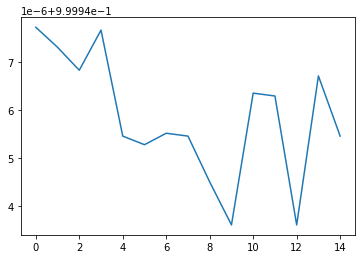

In [50]:
plt.plot(range(len(loss_accumulator)), loss_accumulator)

In [51]:
image_1, t_out_1 = for_plotting(model, r"C:/Users/celes/Desktop/outputs/1332_adjusted_sharpness5.png")
# image_2, t_out_2 = for_plotting(model, "/home/a/Documents/Projects/x_rays/Снимки/ФСИН/0/857.tif")

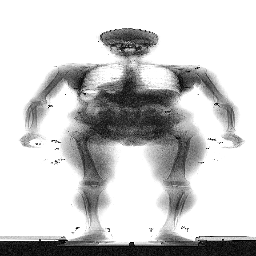

In [52]:
Image.fromarray(
        (image_1*255).squeeze(0).numpy().astype("uint8")
)

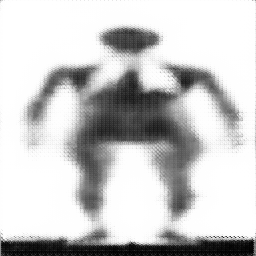

In [53]:
Image.fromarray(
    (t_out_1*255).squeeze(0).squeeze(0).cpu().detach().numpy().astype("uint8")
)

In [57]:
image_1.shape

torch.Size([1, 256, 256])

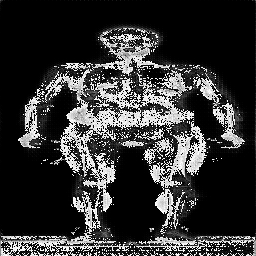

In [61]:
Image.fromarray(
    ((t_out_1.cpu().squeeze(0) - image_1.cpu())*255).squeeze(0).numpy().astype("uint8") * 255
)

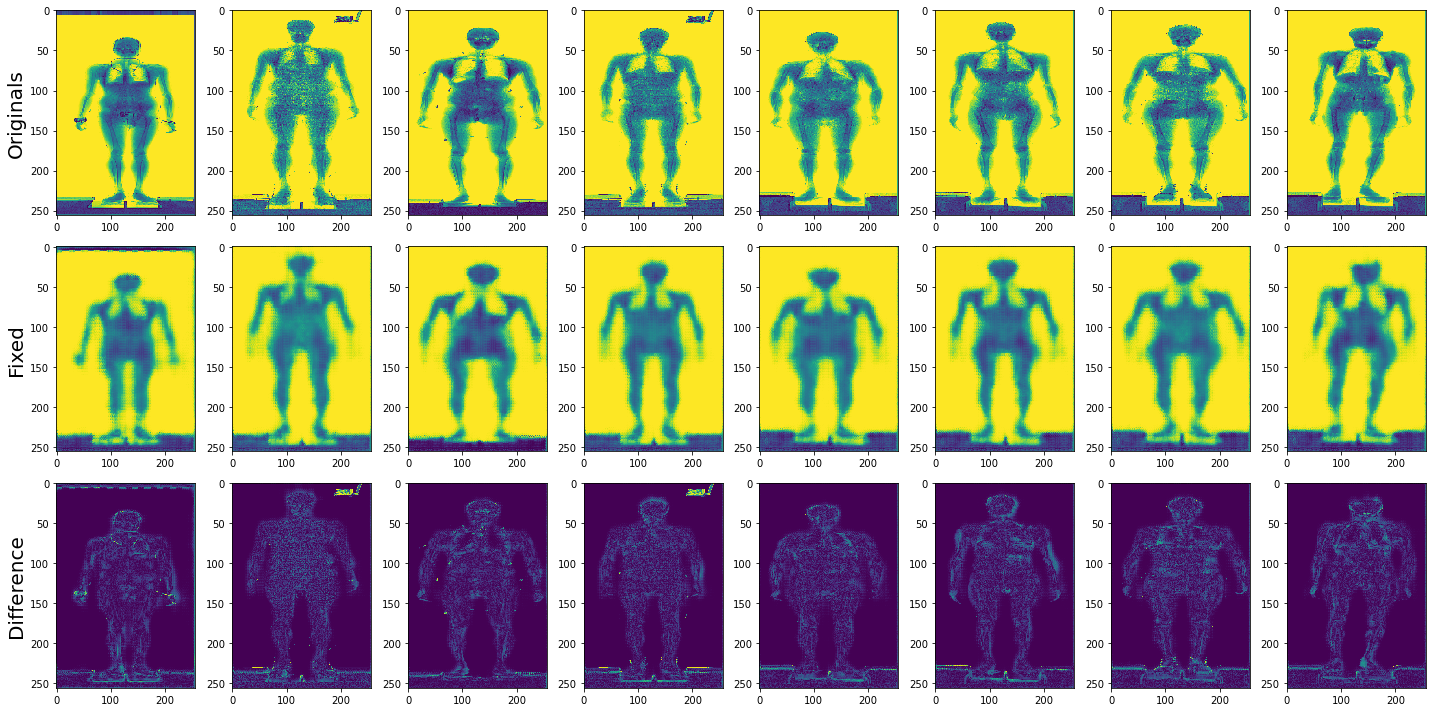

In [48]:
plot_grid(model, paths)

---
# Save

In [13]:
model

Autoencoder(
  (convs): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(11, 11), stride=(1, 1))
    (1): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1))
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (linear_1): Linear(in_features=6400, out_features=200, bias=True)
  (linear_2): Linear(in_features=200, out_features=6400, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (unconvs): ModuleList(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ConvTranspose2d(32, 16, kernel_size=(5, 5), str

In [49]:
torch.save(model.state_dict(), "C:/Users/celes/Desktop/CNN-AE.model")